# Imports

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdmn
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tkr
import pickle
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
import seaborn as sns
import sys

from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from geopandas import sjoin
import sqlite3 as lite
sys.path.append('/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/network_representation/python_scripts/')
import helpers_ses_prediction as hsp
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
from collections import Counter
from scipy.spatial import cKDTree
from collections import Counter


from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')

In [2]:
import pickle
dic_final_not_nan=pickle.load(open(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/all_together_dic.p","rb"))
dic_iris_not_nan=pickle.load(open(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/all_together_dic_iris.p","rb"))

In [ ]:
# home_most_freq_all=go_through_home_candidates(dic_final_not_nan,take_most_frequent)
home_most_freq_night=go_through_home_candidates(dic_final_not_nan,take_most_frequent_night)

home_most_freq_all_iris=go_through_home_candidates(dic_iris_not_nan,take_most_frequent)
home_most_freq_night_iris=go_through_home_candidates(dic_iris_not_nan,take_most_frequent_night)
%clear

# Architect Answers

In [4]:
data_answer_janos=pd.read_excel(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/images_suspected_locs/bigsample_Janos_answer.xlsx",
names=["Index","SES_answer","confidence",])
data_answer_janos["comments"]=np.nan
data_answer_matyas=pd.read_excel(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/images_suspected_locs/bigsample_Matyas_answer.xlsx",
names=["Index","untreated_SES_answer","confidence","comments"])

In [5]:
def categorize(arrs,interv,val):
    return val*np.array([int(x in interv) for x in arrs])

data_answer_matyas.SES_answer=categorize(data_answer_matyas.untreated_SES_answer,list(range(1,4,)),1
                                 )+categorize(data_answer_matyas.untreated_SES_answer,list(range(4,7,)),2
                                             )+categorize(data_answer_matyas.untreated_SES_answer,list(range(7,10,)),3)

In [6]:
import pandas as pd
full_archi_sample_df=pd.read_pickle("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/full_archi_sample.p")

archis=full_archi_sample_df.round({'lat': 2, 'lon': 2}).drop_duplicates(subset=["lat","lon"]).index
full_archi_sample_df_no_dup=full_archi_sample_df.iloc[archis]
ang_list=["tohtml_street_ang_%s"%str(ang) for ang in [-120,-60,0,60,120,180]]

import numpy as np
cols=["Index","id","Latitude","Longitude","Nom_Com","Weekday","Hour"]
y=[]
j=0
for it,item in full_archi_sample_df_no_dup[["id","lat","lon","weekday","hour","nom_com",
                                            "tohtml_zm17","tohtml_zm18","tohtml_zm19"]
                                           +ang_list].iterrows():
    if item.values[-1] and not (None in item.values) and item.values[-2]!=item.values[-3]:
        item["lat"]=np.round(item["lat"],5)
        item["lon"]=np.round(item["lon"],5)
        x=(j,item.id,item.lat,item.lon,item.nom_com,item.weekday,item.hour)
        j+=1
        y.append(x)

n_tot=1000
sample_delivered=y[:n_tot]

data_sample_janos=pd.DataFrame(sample_delivered[:667],columns=cols)
data_janos=pd.merge(data_answer_janos,data_sample_janos,on="Index")
data_janos["author"]="janos"

data_sample_matyas=pd.DataFrame(sample_delivered[333:],columns=cols)
data_matyas=pd.merge(data_answer_matyas,data_sample_matyas,on="Index")
data_matyas["author"]="matyas"


<a id='text_anchor'></a>
# Generate Textual Features

## Profile n-grams

In [8]:
import pickle
import unidecode,re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

#Bio text data
f_accounts="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/all_together_profiles.p"
f_deleted="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/all_together_profiles_deleted_accounts.p"
dic_bio=pickle.load(open(f_accounts,"rb"))
dic_bio_deleted=pickle.load(open(f_deleted,"rb"))

#N-Gram vectorizer
french_stopwords = list(set(stopwords.words('french')))
eng_stopwords = list(set(stopwords.words('english')))
n_grams_bio_vect=TfidfVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=10,ngram_range=(1,2),
                                lowercase=True)

#Clean profile info
tweet_clean = lambda x:' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",
                                       unidecode.unidecode(x.replace("_",""))).split())

#Generate profile info dataframe
cols_of_interest=["id","followers_count","friends_count",
                         "listed_count","favourites_count","statuses_count","description"]
profile_data=[[usr[0]._json[k] for k in cols_of_interest] for usr in dic_bio ]
df_profile_data=pd.DataFrame(profile_data,columns=cols_of_interest)
df_profile_data["description"]=df_profile_data.description.apply(tweet_clean)
n_grams_bio=n_grams_bio_vect.fit_transform(list(df_profile_data.description.values))


# Tweets data
usr_tweet_text=pd.read_csv(
    "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/data_files/UKSOC_rep/tweets/all_geolocated_users.csv",
    sep=';',header=0,)
usr_text=(usr_tweet_text.dropna(how="any").drop(["tweet_id",],axis=1).groupby(
    'user_id',squeeze=True,)['tweet_text'].apply(lambda x: "%s" % ' '.join(x))).to_frame()
usr_text.reset_index(inplace=True)

n_grams_tweet_vect=TfidfVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=1000,ngram_range=(1,2),
                                lowercase=True)

n_grams_tweet=n_grams_tweet_vect.fit_transform(list(usr_text.tweet_text.values))

Load [cluster distribution function](#cluster_info)

In [12]:
from tqdm import tqdm
from collections import Counter
d100=pickle.load(open("/home/jlevyabi/seacabo/data_files/spec_corrected_clusters_only_pos_entries_100.p","rb"))
usr_text=get_cluster_info(d100,usr_text);

100%|██████████| 20830/20830 [02:11<00:00, 158.50it/s]


## Merge profiles and tweets

In [13]:
df_usr_profile_tweets=pd.merge(df_profile_data,usr_text,left_on="id",right_on="user_id")

#Profile Information: Shallow features
mat_shallow_bio=np.vstack([np.hstack(sample.as_matrix()).reshape((1,5))
                            for it,sample in (df_usr_profile_tweets[["followers_count","friends_count",
                                                                     "listed_count",
                                                                     "favourites_count",
                                                                     "statuses_count",]].iterrows())])
#Profile Information: N-grams
n_grams_bio_vect=TfidfVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=10,ngram_range=(1,2),
                                lowercase=True)
mat_n_grams_bio=n_grams_bio_vect.fit_transform(list(df_usr_profile_tweets.description.values)).todense()

#Tweet Information: N-grams
n_grams_tweet_vect=TfidfVectorizer(stop_words=french_stopwords+eng_stopwords,
                                 max_features=1000,ngram_range=(1,1),
                                lowercase=True)
mat_n_grams_tweet=n_grams_tweet_vect.fit_transform(list(df_usr_profile_tweets.tweet_text.values)).todense()

#Tweet Information: Topics
mat_topics_tweet=np.vstack([np.hstack(sample.as_matrix()).reshape((1,100))
                            for it,sample in (df_usr_profile_tweets[["cfd_100",]].iterrows())])

# All non-SES info
data_matrix=np.hstack([mat_n_grams_tweet,mat_n_grams_bio,mat_topics_tweet,mat_shallow_bio])

# Everything combined syntheticly
df_usr_profile_tweets["fts"]=[row for row in data_matrix.tolist()]
df_usr_profile_tweets.drop(["followers_count","friends_count","listed_count","favourites_count",
                           "statuses_count","description","user_id","cfd_100"],inplace=True,axis=1)

In [ ]:
pal=(sns.color_palette("RdBu", n_colors=3))
pal[1]= (1.0, 1.0, 0.0)
plt.figure(figsize=(12,12))
sns.reset_defaults()

plt.subplot(331)
sns.countplot(x="SES_answer", data=data_janos,color="grey");
plt.subplot(332)
sns.countplot(x="confidence", data=data_janos,color="grey");
plt.subplot(333)
sns.countplot(x="confidence",  hue="SES_answer",data=data_janos,palette=pal);

plt.subplot(334)
sns.countplot(x="untreated_SES_answer", data=data_matyas,color="grey");
plt.subplot(335)
sns.countplot(x="confidence", data=data_matyas,color="grey");
plt.subplot(336)
sns.countplot(x="confidence",  hue="untreated_SES_answer",data=data_matyas,palette=pal);

data_overlap=[]
for ses_janos,conf_janos,ses_matyas,conf_matyas,unt_matyas_ses in pre_data_overlap[["SES_answer_janos","confidence_janos",
                                                                     "SES_answer_matyas","confidence_matyas",
                                                                    "Untr_SES_answer"]].values:
    data_overlap.append((ses_janos,conf_janos,0,"janos"))
    data_overlap.append((ses_matyas,conf_matyas,unt_matyas_ses,"matyas"))

data_overlap=pd.DataFrame(data_overlap,columns=["SES_answer","confidence","unt_matyas_ses","author"])

plt.subplot(337)
sns.countplot(x="SES_answer", data=data_overlap,hue="author",);
plt.subplot(338)
sns.countplot(x="confidence", data=data_overlap,hue="author");

In [14]:
df_usr_profile_tweets_janos=pd.merge(df_usr_profile_tweets,data_janos,on="id")
df_usr_profile_tweets_matyas=pd.merge(df_usr_profile_tweets,data_matyas,on="id")

In [15]:
data_matyas.shape

(667, 11)

# Inference Algorithms

## Pipeline of algorithms

### Basic Run

In [16]:
df_usr_profile_tweets_matyas["bianswer"]=(df_usr_profile_tweets_matyas.untreated_SES_answer>5).astype(int)
matyas_to_add=df_usr_profile_tweets_matyas[df_usr_profile_tweets_matyas.untreated_SES_answer!=5]

In [26]:
df_usr_profile_tweets_janos["bianswer"]=(df_usr_profile_tweets_janos.SES_answer>2).astype(int)
janos_to_add=df_usr_profile_tweets_janos[df_usr_profile_tweets_janos.SES_answer!=2]
janos_to_add["SES_answer"]=(janos_to_add["SES_answer"]>1).astype(int)

In [41]:
ses_text=pd.concat([matyas_to_add,janos_to_add])
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text.iloc[0]["fts"])))
                            for it,sample in (ses_text[["fts",]].iterrows())])
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text.iloc[0]["fts"])))
                            for it,sample in (ses_text[["fts",]].iterrows())])

X = StandardScaler().fit_transform(mat_info)
classes=np.array(ses_text.bianswer)
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=.2, random_state=42)


In [45]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes",]

classifiers = [
    KNeighborsClassifier(10),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = classification_report(y_test,clf.predict(X_test))
    print(score)
    #print ("%d-Classification accuracy for %s:  %f"%(len(set(classes)),name,score))

             precision    recall  f1-score   support

          0       0.61      0.72      0.66        47
          1       0.61      0.48      0.53        42

avg / total       0.61      0.61      0.60        89

             precision    recall  f1-score   support

          0       0.59      0.55      0.57        47
          1       0.53      0.57      0.55        42

avg / total       0.56      0.56      0.56        89

             precision    recall  f1-score   support

          0       0.71      0.11      0.19        47
          1       0.49      0.95      0.65        42

avg / total       0.61      0.51      0.40        89

             precision    recall  f1-score   support

          0       0.54      0.55      0.55        47
          1       0.49      0.48      0.48        42

avg / total       0.52      0.52      0.52        89

             precision    recall  f1-score   support

          0       0.53      0.68      0.60        47
          1       0.48      0.33 

### Random Forest Tuning

In [46]:
from operator import itemgetter
from collections import defaultdict, Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer, StandardScaler, scale
from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score, brier_score_loss, make_scorer, f1_score, fbeta_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from scipy.stats import uniform
from xgboost import XGBClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=1)
param_distributions = {'criterion': ['gini', 'gini', 'entropy'],
                       'max_depth': range(2,50),
                       'min_samples_split': uniform(loc=0, scale=0.2),
                       'min_samples_leaf': uniform(loc=0, scale=0.2),
                       'bootstrap': [True, True, False]}

n_splits = 5
n_repeats = 5
n_iter = 100
n_jobs = -1
verbose = 1

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
model = RandomizedSearchCV(clf, param_distributions, n_iter=n_iter, scoring=scorer, n_jobs=n_jobs, cv=cv, verbose=verbose)

model.fit(X_train, y_train)
print("Best model parameters: ", model.best_params_)
print("Best model roc auc score: ", model.best_score_)

Fitting 25 folds for each of 100 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   39.4s finished


Best model parameters:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 27, 'min_samples_leaf': 0.08901983322596185, 'min_samples_split': 0.18435797603251014}
Best model roc auc score:  0.5859523809523809


In [48]:
(model.best_estimator_)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=27, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.08901983322596185,
            min_samples_split=0.18435797603251014,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
print(classification_report(y_test,model.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.60      0.70      0.65        47
          1       0.59      0.48      0.53        42

avg / total       0.59      0.60      0.59        89



In [51]:
fitted_clf = RandomForestClassifier(n_estimators=1000, n_jobs=10,
                                   bootstrap=False, criterion='gini',max_depth= 26,
                                    min_samples_leaf= 0.0033978733943459405,
                                    min_samples_split=0.03500328463953173)
fitted_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.0033978733943459405,
            min_samples_split=0.03500328463953173,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

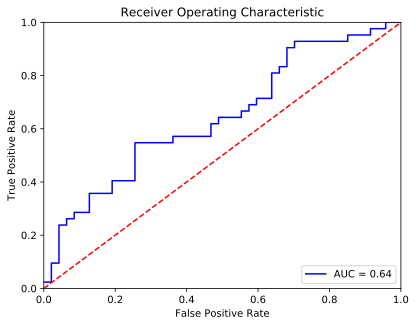

In [52]:
probs = fitted_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [53]:
import pickle
d_test_brunch={"Xtrain":X_train,"Xtest":X_test,"Ytrain":y_train,"Ytest":y_test}
pickle.dump(d_test_brunch,
            open( "/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/icdm18/issues/archi_xgb_data.p","wb"))

In [ ]:
X = StandardScaler().fit_transform(mat_info)
classes=np.array(ses_text.bianswer)
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=.2, random_state=42)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = roc_auc_score(y_test,clf.predict(X_test))
    print ("%d-Classification accuracy for %s:  %f"%(len(set(classes)),name,score))

In [158]:
from sklearn.metrics import classification_report
print(classification_report(classes,fitted_clf.predict(X)))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95       428
          1       0.06      0.03      0.04        31

avg / total       0.87      0.90      0.88       459



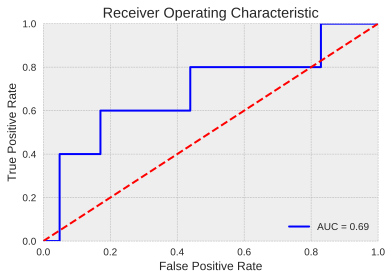

In [145]:
probs = fitted_clf.predict_proba(new_X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(new_y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [192]:
dic_archi_xgb={
    "fpr":fpr,
    "tpr":tpr,
    "roc_auc":roc_auc,
}
import pickle
pickle.dump(dic_archi_xgb,open("/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/ml_soc_econ/icdm18/issues/dic_archi_xgb.p","wb"))

In [ ]:
probs = fitted_clf.predict_proba(new_X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(new_classes, preds)
roc_auc = metrics.auc(fpr, tpr)




# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [134]:
df_usr_profile_tweets_janos["bianswer"]=(df_usr_profile_tweets_janos.SES_answer>2).astype(int)

new_ses_text=df_usr_profile_tweets_janos
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes",]

new_mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text.iloc[0]["fts"])))
                            for it,sample in (new_ses_text[["fts",]].iterrows())])

new_X = StandardScaler().fit_transform(new_mat_info)
new_classes=np.array(new_ses_text.bianswer)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_classes, test_size=.1)

## Extend learning to network information

In [67]:
f_embed="/warehouse/COMPLEXNET/jlevyabi/TWITTERSES/network_representation/data_files/network_files/embeddings/node2vec.emb"
with open(f_embed, 'r') as f:
    first_line = f.readline()
f.close()
dim_embed=int(first_line.split()[1])
net_cols=["dim_"+str(i) for i in range(dim_embed)]

network_emb=pd.read_csv(sep=" ",skiprows=[0],names=["id"]+net_cols,
    filepath_or_buffer=f_embed,)
usr_embed=np.array(network_emb[net_cols])
network_emb["n2v"]=[line for line in usr_embed]

network_emb=network_emb[["id","n2v"]]


In [39]:
ses_text_n2v_iris=pd.merge(ses_text_iris,network_emb,
                          left_on="usr",right_on="id")
ses_iris_n2v_class_try=np.array(ses_text_n2v_iris.DEC_D913>
                            np.mean(ses_text_n2v_iris.DEC_D913)).astype(np.int)# 2 class

mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_iris.iloc[0]["fts"])))
                            for it,sample in (ses_text_iris[["fts",]].iterrows())])

In [54]:
inter=[]
for row_1,row_2 in zip(ses_text_n2v_iris.fts,ses_text_n2v_iris.n2v):
    inter.append(np.hstack([np.array(row_1),np.array(row_2)]))

ses_text_n2v_iris["n2v+fts"]=inter

In [56]:
mat_info=np.vstack([np.hstack(sample.as_matrix()).reshape((1,len(ses_text_n2v_iris.iloc[0]["n2v+fts"])))
                            for it,sample in (ses_text_n2v_iris[["n2v+fts",]].iterrows())])

## Generate cluster information

In [9]:
def get_cluster_info(dic_clus,df_tweets):
    nb_clusters=len(list(dic_clus.keys()))
    word2cluster_only_pos={word:cluster_nb for cluster_nb,cluster_words in dic_clus.items() for word in cluster_words}
    clust_freq_only_pos=[]
    for tweet in tqdm(df_tweets.tweet_text):
        clust_freq_only_pos.append((Counter([word2cluster_only_pos[word]
                                             for word in tweet.split() if word in word2cluster_only_pos])))
    cfd_only_pos=[{k:(v+0.0)/(sum(dic_count.values()))for k,v in dic_count.items()}
                  for dic_count in clust_freq_only_pos]
    df_tweets["cfd_%d"%nb_clusters]=[np.array(list({clus:(dic_count[clus] if clus in dic_count else 0)
                                    for clus in range(len(dic_clus))}.values())) for dic_count in cfd_only_pos]
    return (df_tweets)